In [1]:
# Import all necessary libraries and setup the environment for matplotlib
%matplotlib inline
import findspark
import time
import pandas as pd
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
from sklearn.metrics import accuracy_score

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

def RFClassifier(training_data, test_data, nTrees,features):

    start = time.time()
    
    
    labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(training_data)
    featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures")
    labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)
    # Training model
    rf = RandomForestClassifier(labelCol="indexedLabel", 
                                featuresCol=features, numTrees=nTrees)
    pipeline = Pipeline(stages=[labelIndexer, rf,labelConverter])
    model=pipeline.fit(training_data)
    # Prediction
    predictions = model.transform(test_data)
    #predictions.show()
    # Accuracy
    evaluator = MulticlassClassificationEvaluator(
        labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(accuracy)
    
    end = time.time()
    runtime=round(end - start, 2)
    print('Time: {}s'.format(runtime))
    
    return accuracy,runtime

In [3]:
def PCA_reduction(training_data,test_data,num):
    start = time.time() # time counting
    pca = PCA(k=num, inputCol='features', outputCol='pca') #PCA implementing
    model = pca.fit(training_data)
    recontructed_training_data = model.transform(training_data).select('label','features','pca')
    recontructed_test_data = model.transform(test_data).select('label','features','pca')
    end = time.time()
    print('Explained Variance: {}, Time: {}s'.format(round(model.explainedVariance.sum(),3), round(end - start, 2)))
    return recontructed_training_data, recontructed_test_data

In [4]:
spark = SparkSession \
    .builder \
    .appName("Python Spark Machine Learning Random forest") \
    .getOrCreate()
start = time.time()

test_datafile= "Test-label-28x28.csv"
train_datafile = "Train-label-28x28.csv"


test_df = spark.read.csv(test_datafile,header=False,inferSchema="true")
train_df = spark.read.csv(train_datafile,header=False,inferSchema="true")

print('Number of test data: ',test_df.count())
print('Number of training data: ',train_df.count())

# Give header to the column
assembler = VectorAssembler(inputCols=test_df.columns[1:],
    outputCol="features")
test_data = assembler.transform(test_df).select(test_df[0].alias('label'),"features")
training_data = assembler.transform(train_df).select(train_df[0].alias('label'),"features")
data = training_data.union(test_data)

    
end = time.time()
print('Time: {}s'.format(round(end - start, 2)))

Number of test data:  10000
Number of training data:  60000
Time: 9.38s


In [5]:
training_data_pca,test_data_pca=PCA_reduction(training_data,test_data,50)


Explained Variance: 0.825, Time: 12.45s


In [6]:
# Analysis with different number of trees
timeList=list()
accuracyList=list()
for num in range(10,101,10):
    a,t=RFClassifier(training_data_pca,test_data_pca,num,'pca')
    timeList.append(t)
    accuracyList.append(a)

0.7518
Time: 21.83s
0.7658
Time: 15.46s
0.8019
Time: 18.22s
0.799
Time: 16.08s
0.8006
Time: 15.36s
0.8048
Time: 18.0s
0.8155
Time: 17.62s
0.8032
Time: 18.48s
0.8089
Time: 18.49s
0.8108
Time: 20.73s


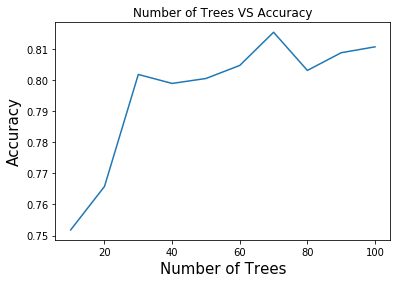

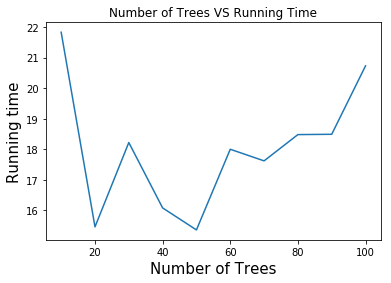

In [7]:
# Plot
x=np.arange(10,101,10)
plt.title( 'Number of Trees VS Accuracy')  
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Number of Trees',fontsize=15)
plt.plot(x,np.array(accuracyList))
plt.show()

x=np.arange(10,101,10)
plt.title( 'Number of Trees VS Running Time')  
plt.ylabel('Running time',fontsize=15)
plt.xlabel('Number of Trees',fontsize=15)
plt.plot(x,np.array(timeList))
plt.show()


In [8]:
spark.stop()